In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
claims_df = pd.read_csv('../data/processed/dim_claims_train.csv').fillna(0)
date_df = pd.read_csv('../data/processed/dim_date_train.csv', parse_dates=[1])
pa_df = pd.read_csv('../data/processed/dim_pa_train.csv')
bridge_df = pd.read_csv('../data/processed/bridge_train.csv')
merged = bridge_df.merge(claims_df, on='dim_claim_id').merge(date_df, on='dim_date_id').merge(pa_df, on='dim_pa_id')

# Prior Authorization Volume
## How does the total prior authorization (PA) volume change with time?
- The time dependence is consistent with what was observed in the claims data. This observation is self-consistent, because each payer has a constant rate of approval for each drug, resulting in a constant proportion of claims being converted to PAs.

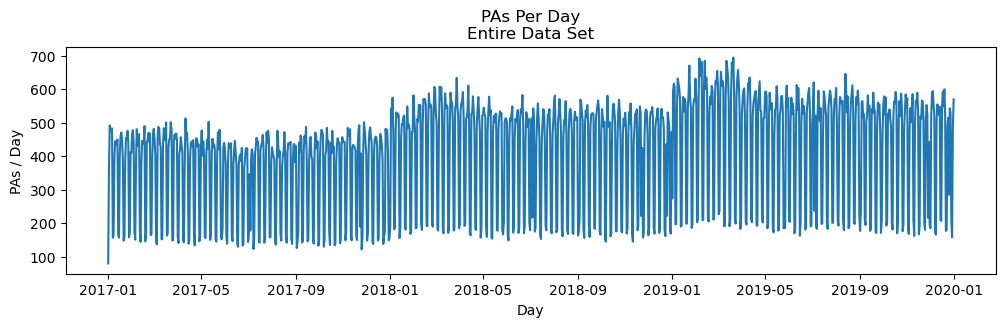

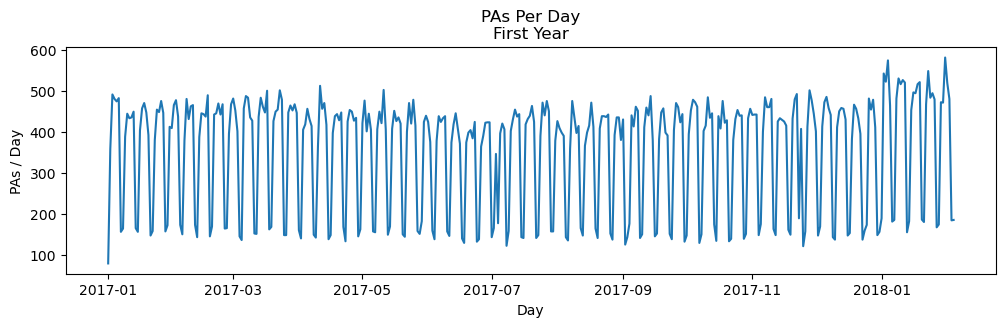

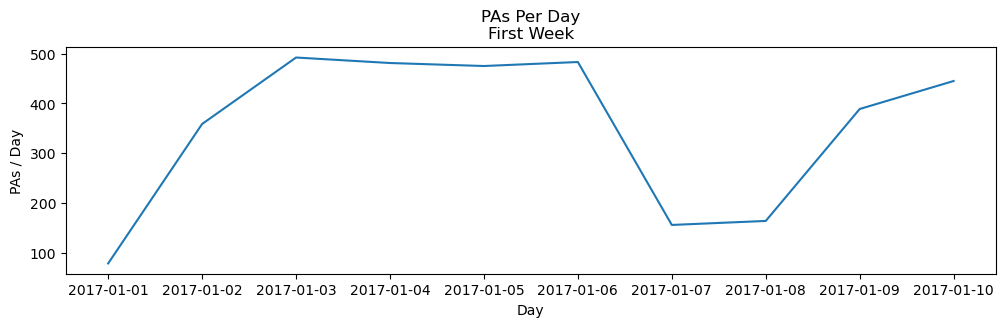

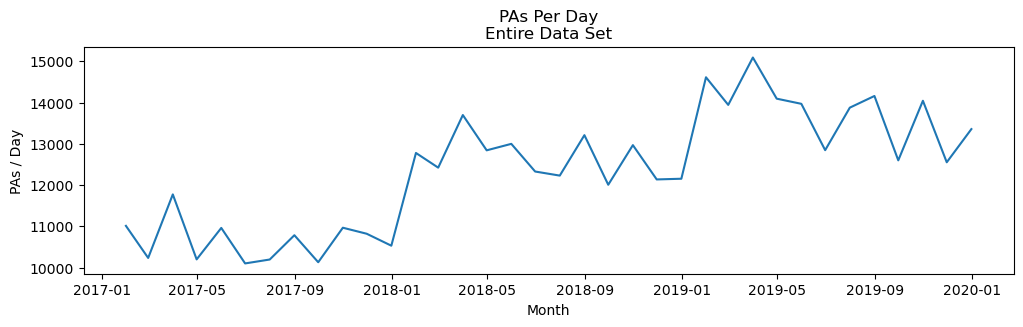

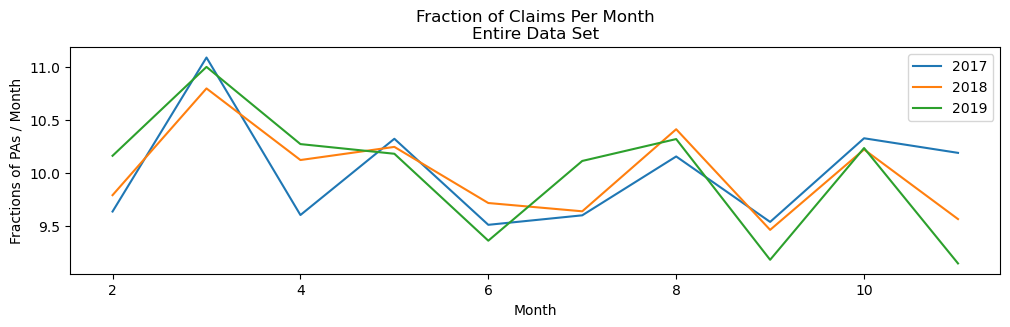

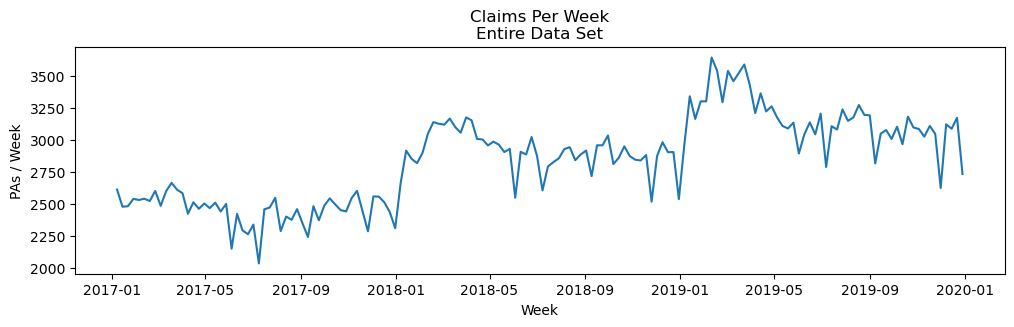

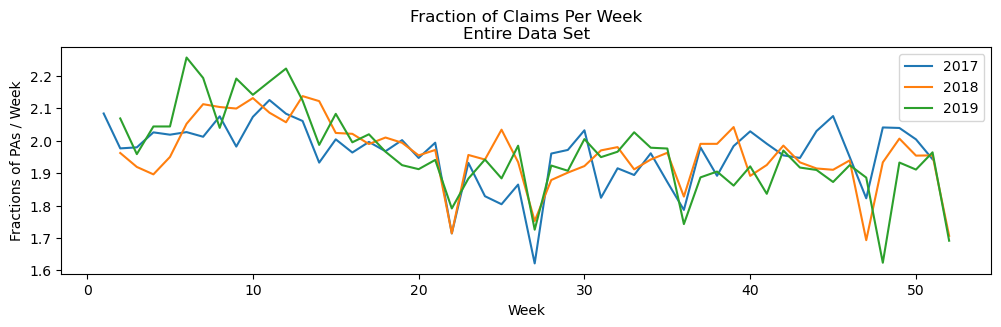

In [3]:
merged = bridge_df.merge(pa_df, on='dim_pa_id').merge(date_df, on='dim_date_id')
f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nEntire Data Set')
plt.plot(merged.groupby('date_val')['pa_approved'].count())
plt.ylabel('PAs / Day')
plt.xlabel('Day')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nFirst Year')
plt.plot(merged.groupby('date_val')['pa_approved'].count().iloc[:400])
plt.ylabel('PAs / Day')
plt.xlabel('Day')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nFirst Week')
plt.plot(merged.groupby('date_val')['pa_approved'].count().iloc[:10])
plt.ylabel('PAs / Day')
plt.xlabel('Day')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nEntire Data Set')
plt.plot(merged.groupby('date_val').count().groupby(pd.Grouper(freq='M'))['pa_approved'].sum())
plt.ylabel('PAs / Day')
plt.xlabel('Month')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
for year, view in merged.groupby('calendar_year'):
    view = view.groupby('date_val').count().groupby(pd.Grouper(freq='M'))['pa_approved'].sum()[1:-1]
    view = view / view.sum() * 100

    plt.title('Fraction of Claims Per Month\nEntire Data Set')
    plt.plot(np.array(view.index.month).astype(int), view.values, label=year)
    plt.ylabel('Fractions of PAs / Month')
    plt.xlabel('Month')
plt.legend()
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('Claims Per Week\nEntire Data Set')
# need to truncate the first and last bins because the weeks are incomplete
plt.plot(merged.groupby('date_val').count().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1])
plt.ylabel('PAs / Week')
plt.xlabel('Week')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
for year, view in merged.groupby('calendar_year'):
    # need to truncate the first and last bins because the weeks can be incomplete
    view = view.groupby('date_val').count().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1]
    view = view / view.sum() * 100

    plt.title('Fraction of Claims Per Week\nEntire Data Set')
    plt.plot(np.array(view.index.isocalendar().week).astype(int), view.values, label=year)
    plt.ylabel('Fractions of PAs / Week')
    plt.xlabel('Week')
plt.legend()
plt.show()

# Prior Authorization Approval Rate
## How does PA approval rate change with time for each payer/drug combination?
- Aggregation by week and month is required to obtain smooth rates due to the small number of PAs each day.
- No trends in PA authorization rate.

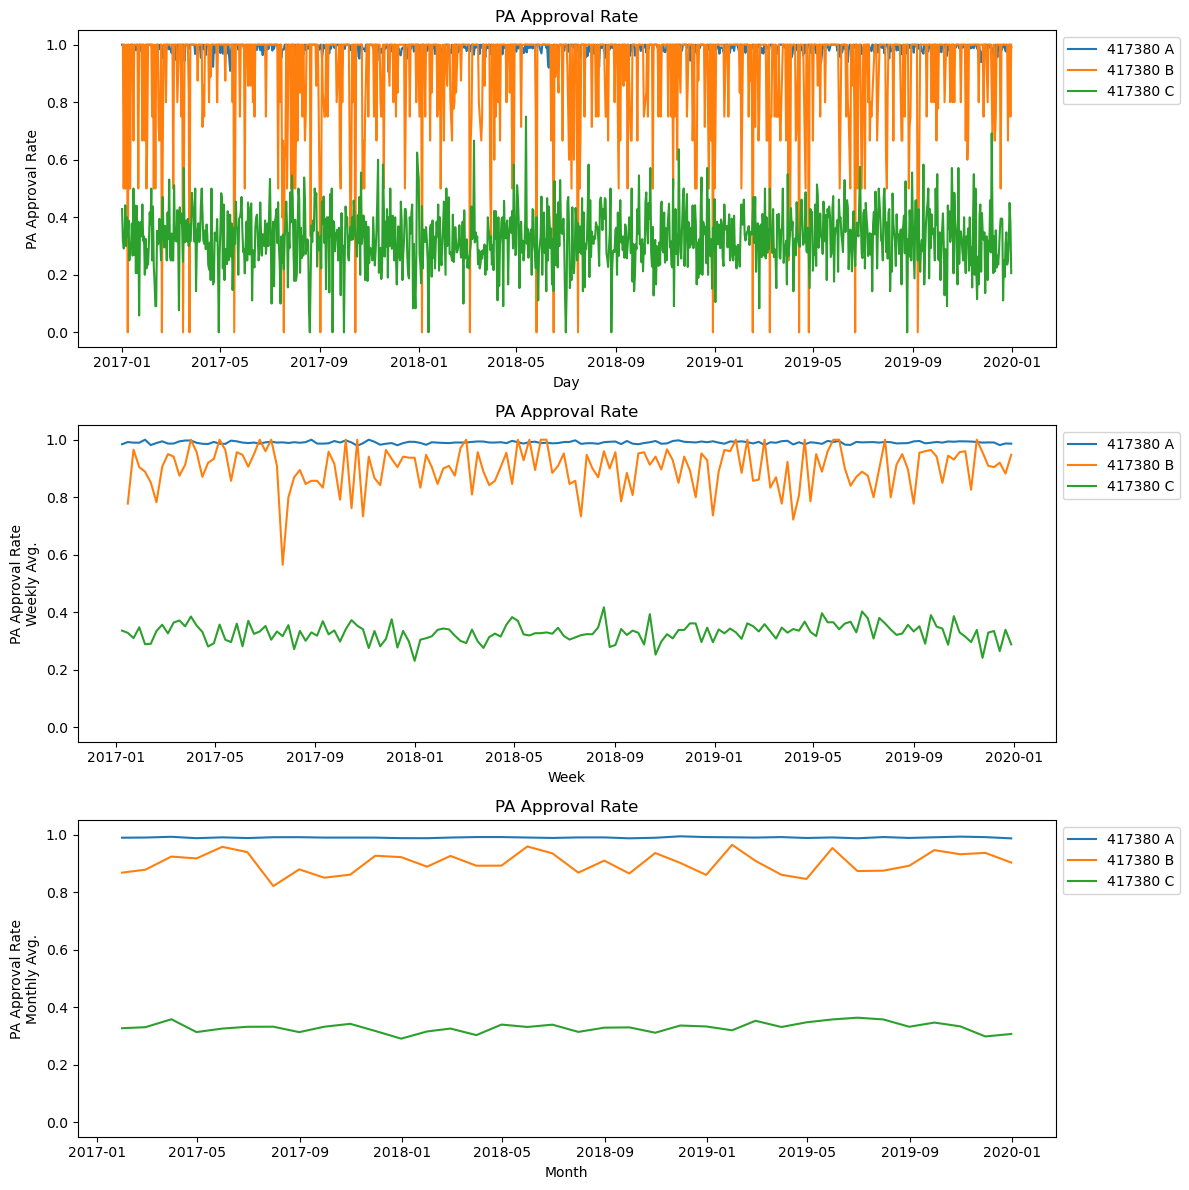

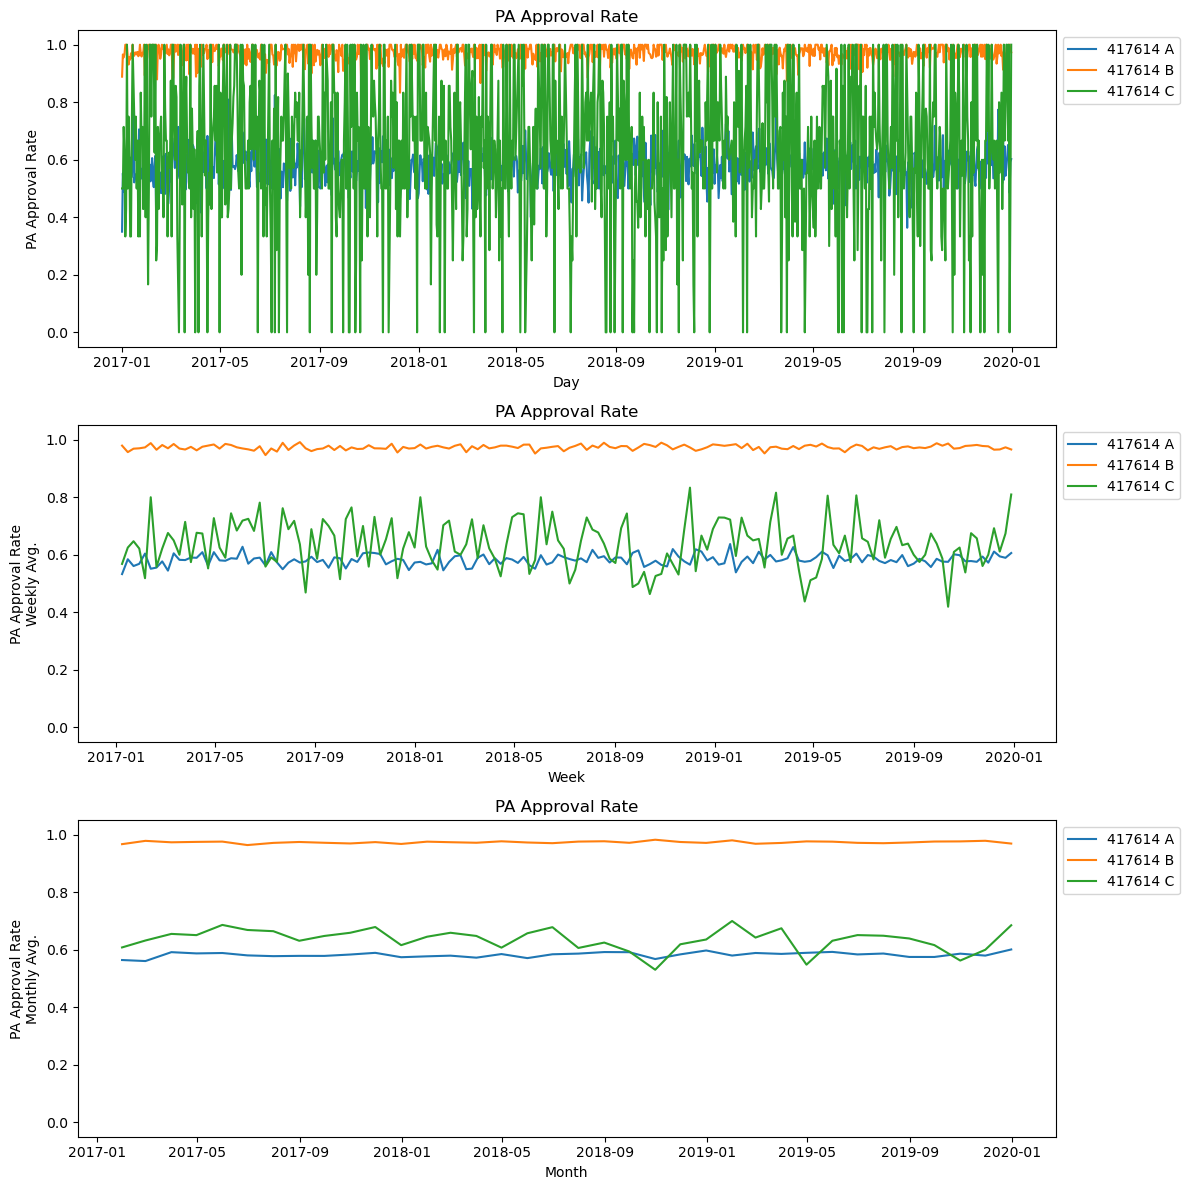

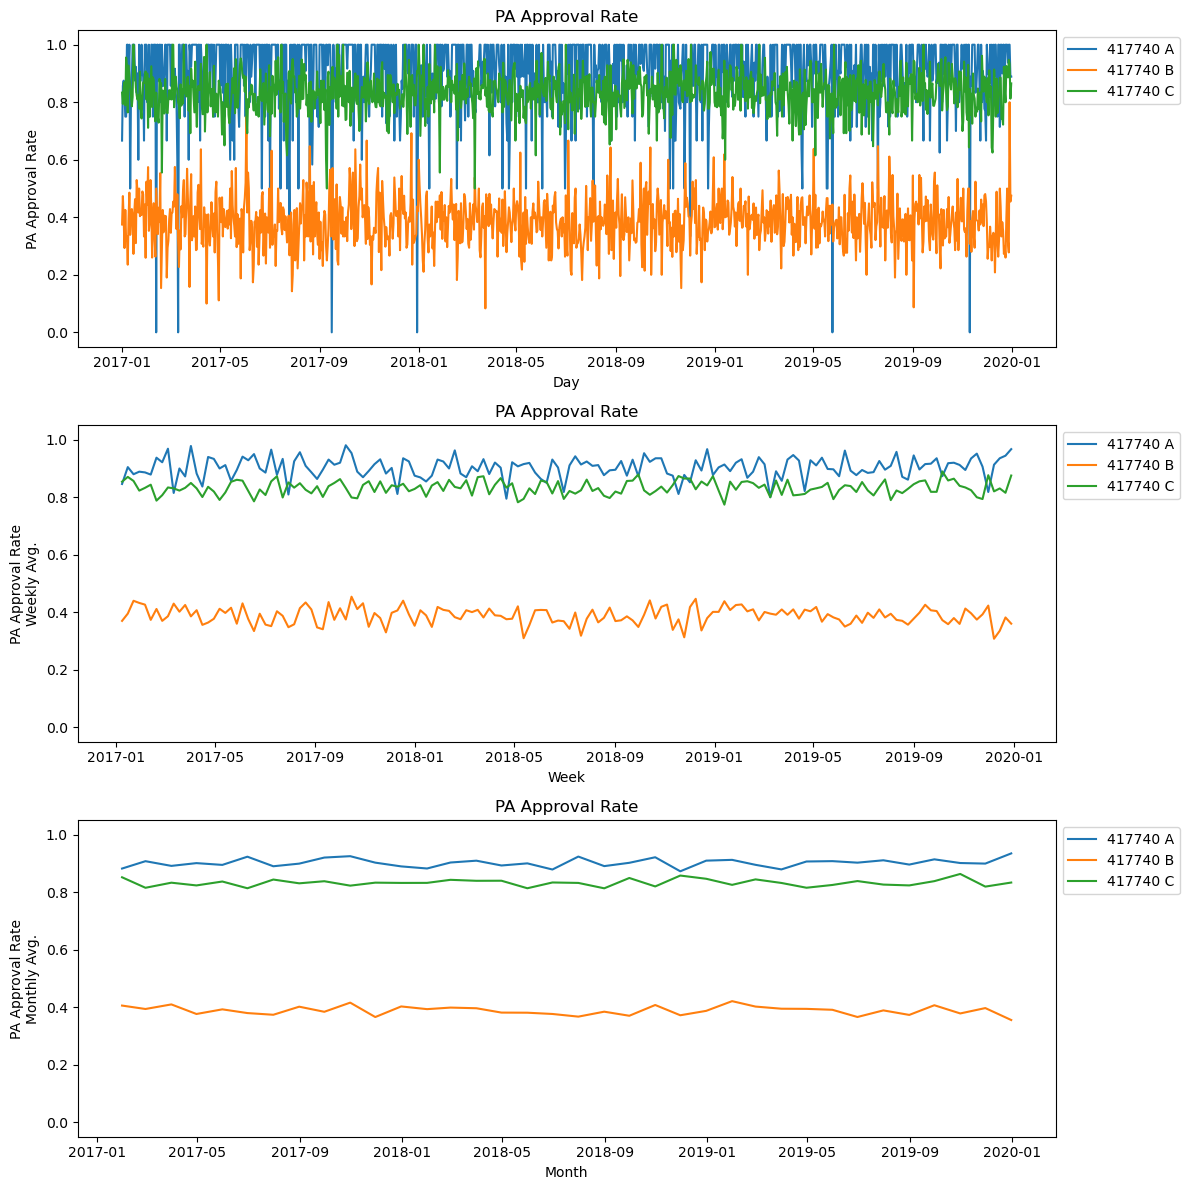

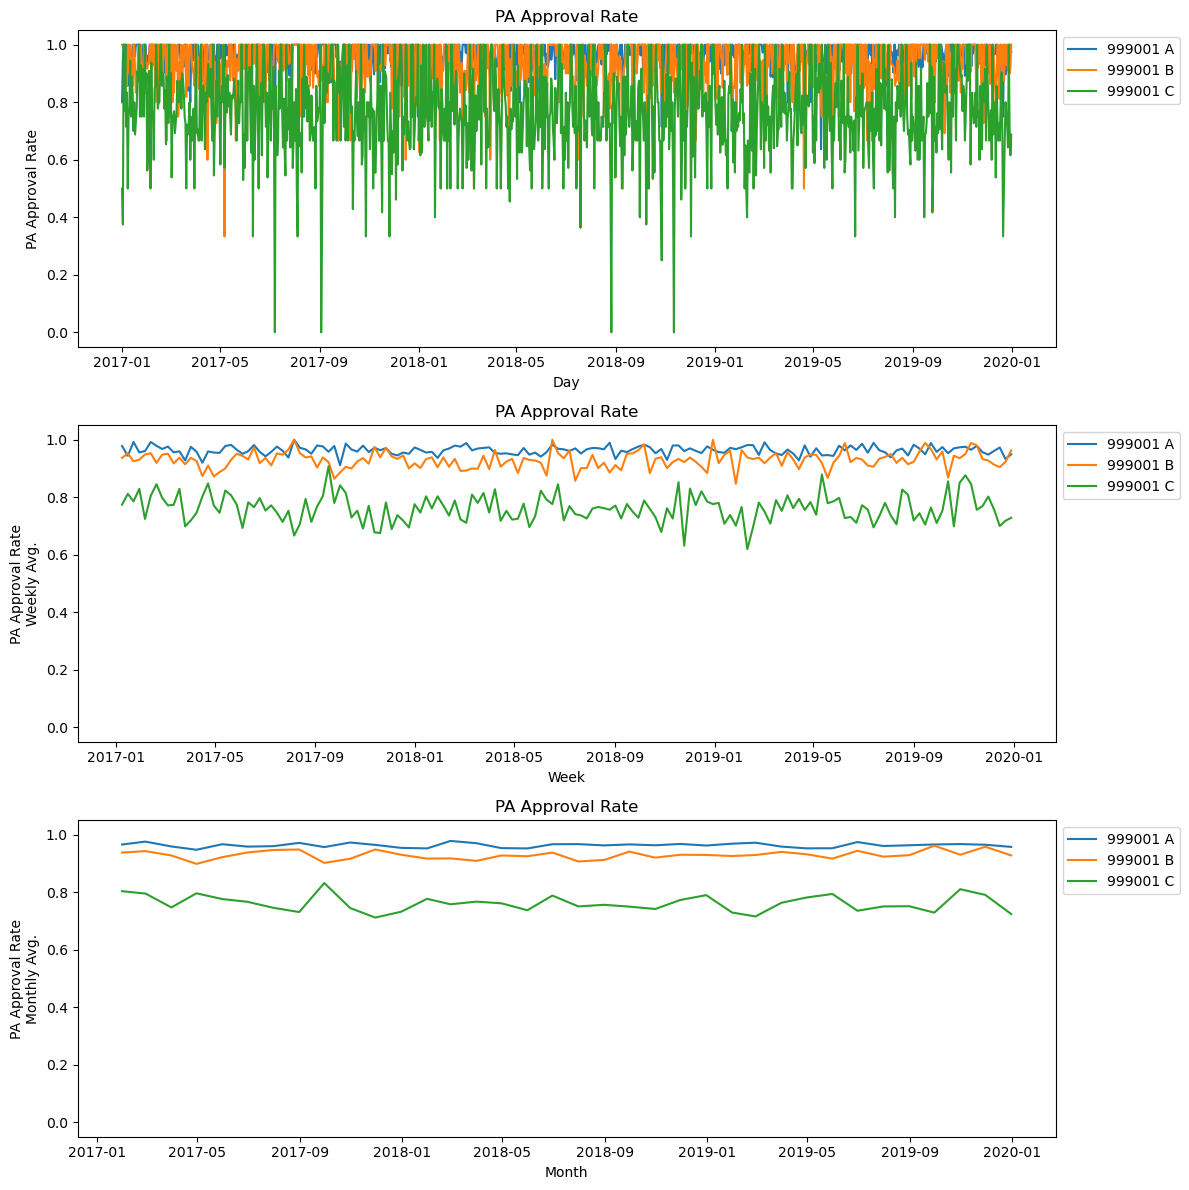

In [5]:
merged = bridge_df.merge(claims_df, on='dim_claim_id').merge(date_df, on='dim_date_id').merge(pa_df, on='dim_pa_id')

# sort the payer labels so that the legends appear in sorted order
for payer in sorted(merged['bin'].unique()):
    f, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=100)
    for drug in merged['drug'].unique():
        segment = merged.loc[(merged['bin'] == payer) & (merged['drug'] == drug)]
        axes[0].set_title('PA Approval Rate')
        approved = segment.groupby('date_val')['pa_approved'].sum()
        total = segment.groupby('date_val')['pa_approved'].count()
        axes[0].plot(approved / total, label=str(payer) + ' ' + drug)
        axes[0].set_ylabel('PA Approval Rate')
        axes[0].set_xlabel('Day')

        axes[1].set_title('PA Approval Rate')
        approved = segment.groupby('date_val').sum().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1]
        total = segment.groupby('date_val').count().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1]
        axes[1].plot(approved / total, label=str(payer) + ' ' + drug)
        axes[1].set_ylabel('PA Approval Rate\nWeekly Avg.')
        axes[1].set_xlabel('Week')
        
        axes[2].set_title('PA Approval Rate')
        approved = segment.groupby('date_val').sum().groupby(pd.Grouper(freq='M'))['pa_approved'].sum()
        total = segment.groupby('date_val').count().groupby(pd.Grouper(freq='M'))['pa_approved'].sum()
        axes[2].plot(approved / total, label=str(payer) + ' ' + drug)
        axes[2].set_ylabel('PA Approval Rate\nMonthly Avg.')
        axes[2].set_xlabel('Month')
        

    for ax in axes:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

## How does the average PA approval rate change with year (`calendar_year`)?
- No significant change in average rate of claim approval with year.

In [6]:
for year, view in merged.groupby('calendar_year'):
    print(f"{round(100 * view['pa_approved'].mean(), 1)}% of PAs ({view['pa_approved'].count()} records) are approved in {year}.")

73.2% of PAs (127713 records) are approved in 2017.
73.5% of PAs (151794 records) are approved in 2018.
73.8% of PAs (165175 records) are approved in 2019.


## How does the average PA approval rate change with month (`calendar_month`)?
- No significant change in average rate of claim approval with month.

In [7]:
months = {1: 'January',
          2: 'February',
          3: 'March',
          4: 'April',
          5: 'May',
          6: 'June',
          7: 'July',
          8: 'August',
          9: 'September',
          10: 'October',
          11: 'November',
          12: 'December'}
for month, view in merged.groupby('calendar_month'):
    print(f"{round(100 * view['pa_approved'].mean(), 1)}% of PAs ({view['pa_approved'].count()} records) are approved in {months[month]}.")

73.5% of PAs (38408 records) are approved in January.
73.5% of PAs (36604 records) are approved in February.
73.6% of PAs (40570 records) are approved in March.
73.6% of PAs (37140 records) are approved in April.
73.5% of PAs (37935 records) are approved in May.
73.4% of PAs (35279 records) are approved in June.
73.2% of PAs (36306 records) are approved in July.
73.0% of PAs (38159 records) are approved in August.
73.7% of PAs (34740 records) are approved in September.
73.6% of PAs (37983 records) are approved in October.
73.7% of PAs (35513 records) are approved in November.
73.7% of PAs (36045 records) are approved in December.


## How does the average PA approval rate change with day of the week (`day_of_week`)?
- No significant change in average rate of claim approval with day of the week.

In [8]:
days = {1: 'Sunday',
        2: 'Monday',
        3: 'Tuesday',
        4: 'Wednesday',
        5: 'Thursday',
        6: 'Friday',
        7: 'Saturday'}
for day, view in merged.groupby('day_of_week'):
    print(f"{round(100 * view['pa_approved'].mean(), 1)}% of PAs ({view['pa_approved'].count()} records) are approved in {days[day]}.")

73.4% of PAs (27085 records) are approved in Sunday.
73.3% of PAs (71466 records) are approved in Monday.
73.7% of PAs (81057 records) are approved in Tuesday.
73.6% of PAs (80793 records) are approved in Wednesday.
73.5% of PAs (80032 records) are approved in Thursday.
73.5% of PAs (77116 records) are approved in Friday.
73.4% of PAs (27133 records) are approved in Saturday.


## How does the average PA approval rate change if it is a workday (`is_workday`)?
- No significant change in average rate of claim approval with day of the week.

In [9]:
for workday, view in merged.groupby('is_workday'):
    if workday:
        text = 'on a workday'
    else:
        text = 'on a non-workday'
    print(f"{round(100 * view['pa_approved'].mean(), 1)}% of PAs ({view['pa_approved'].count()} records) are approved {text}.")

73.4% of PAs (60410 records) are approved on a non-workday.
73.5% of PAs (384272 records) are approved on a workday.


## How does the average PA approval rate change if it is a holiday (`is_holiday`)?
- No significant change in average rate of claim approval with day of the week.

In [10]:
for workday, view in merged.groupby('is_holiday'):
    if workday:
        text = 'on a holiday'
    else:
        text = 'on a non-holiday'
    print(f"{round(100 * view['pa_approved'].mean(), 1)}% of PAs ({view['pa_approved'].count()} records) are approved {text}.")

73.5% of PAs (440996 records) are approved on a non-holiday.
73.8% of PAs (3686 records) are approved on a holiday.


## How does the combination of payer (`bin`), and reject code (`reject_code`) influence the average rate of PA approval, with respect to time?
- No significant change in average rate of claim approval for any of the combinations.

In [11]:
time_names = ['calendar_year', 'is_workday', 'is_holiday']

for time_name in time_names:
    split = pd.DataFrame(merged.groupby(['bin', 'drug', time_name])['pa_approved'].mean())
    split.loc[:, 'pa_approved_count'] = merged.groupby(['bin', 'drug', time_name])['pa_approved'].count()
    split = split.rename(columns={'pa_approved': 'pa_approved_percent'})
    display(split.loc[split['pa_approved_percent'] > 0].sort_index(level=[0, 1, 2]))

pa_approved_percent  pa_approved_count
bin    drug calendar_year                                        
417380 A    2017                      0.990030              19157
            2018                      0.990411              24820
            2019                      0.990323              26867
       B    2017                      0.896486               1053
            2018                      0.904841               1198
            2019                      0.908946               1252
       C    2017                      0.327284              10028
            2018                      0.325875              10771
            2019                      0.338052              11655
417614 A    2017                      0.579867              34044
            2018                      0.582276              43646
            2019                      0.585399              47489
       B    2017                      0.972164              18968
            2018                      0.974705              20834
            2019                      0.974166              23070
       C    2017                      0.650438               1828
            2018                      0.624659               1833
            2019                      0.634328               2010
417740 A    2017                      0.902504               2236
            2018                      0.899355               3100
            2019                      0.904979               3294
       B    2017                      0.392608              13204
            2018                      0.385053              14772
            2019                      0.389931              15990
       C    2017                      0.831554              12461
            2018                      0.834909              13326
            2019                      0.832317              14432
999001 A    2017                      0.962974               6968
            2018                      0.963579               9143
            2019                      0.963182               9968
       B    2017                      0.930087               4005
            2018                      0.922989               4350
            2019                      0.934392               4786
       C    2017                      0.764956               3761
            2018                      0.762559               4001
            2019                      0.755846               4362

pa_approved_percent  pa_approved_count
bin    drug is_workday                                        
417380 A    0                      0.990871               9640
            1                      0.990180              61204
       B    0                      0.889583                480
            1                      0.906054               3023
       C    0                      0.329839               4293
            1                      0.330812              28161
417614 A    0                      0.578673              17096
            1                      0.583459             108083
       B    0                      0.970805               8529
            1                      0.974201              54343
       C    0                      0.625698                716
            1                      0.637941               4955
417740 A    0                      0.895359               1185
            1                      0.903425               7445
       B    0                      0.379216               5870
            1                      0.390618              38096
       C    0                      0.831996               5482
            1                      0.833089              34737
999001 A    0                      0.960257               3573
            1                      0.963743              22506
       B    0                      0.935519               1830
            1                      0.928300              11311
       C    0                      0.782051               1716
            1                      0.757398              10408

pa_approved_percent  pa_approved_count
bin    drug is_holiday                                        
417380 A    0                      0.990234              70246
            1                      0.994983                598
       B    0                      0.903819               3483
            1                      0.900000                 20
       C    0                      0.330837              32185
            1                      0.312268                269
417614 A    0                      0.583035             124183
            1                      0.554217                996
       B    0                      0.973755              62336
            1                      0.972015                536
       C    0                      0.636461               5628
            1                      0.627907                 43
417740 A    0                      0.902316               8548
            1                      0.902439                 82
       B    0                      0.388879              43628
            1                      0.417160                338
       C    0                      0.832869              39879
            1                      0.841176                340
999001 A    0                      0.963217              25854
            1                      0.968889                225
       B    0                      0.929301              13013
            1                      0.929688                128
       C    0                      0.760926              12013
            1                      0.756757                111

## How does the combination of payer (`bin`), and reject code (`reject_code`) influence the average rate of claim approval, with respect to time?
- No significant change in average rate of claim approval for any of the combinations.

In [12]:
for payer in np.sort(merged['bin'].unique()):
    for drug in merged['drug'].unique():
        split = merged.loc[(merged['bin'] == payer) & (merged['drug'] == drug)]
        split = pd.DataFrame(split.groupby(['calendar_year', 'calendar_month'])['pa_approved'].mean())
        split.loc[:, 'pharmacy_claim_approved_count'] = merged.groupby(['calendar_year', 'calendar_month'])['pa_approved'].count()
        split = split.rename(columns={'pa_approved': 'pa_approved_percent'})
        split = split.loc[split['pa_approved_percent'] > 0]
        if len(split) > 0:
            print(f'Segment with payer {payer} and drug {drug}')
            display(split.sort_index(level=[0, 1]))

Segment with payer 417380 and drug A


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.989597   
              2                          0.990169   
              3                          0.992754   
              4                          0.987952   
              5                          0.990879   
              6                          0.988364   
              7                          0.991273   
              8                          0.991406   
              9                          0.990000   
              10                         0.990033   
              11                         0.989922   
              12                         0.988037   
2018          1                          0.987856   
              2                          0.990143   
              3                          0.991859   
              4                          0.991858   
              5                          0.990210   
              6                          0.988797   
              7                          0.990603   
              8                          0.990663   
              9                          0.987456   
              10                         0.989440   
              11                         0.994430   
              12                         0.991774   
2019          1                          0.991049   
              2                          0.990081   
              3                          0.991746   
              4                          0.988636   
              5                          0.990532   
              6                          0.987578   
              7                          0.991899   
              8                          0.988788   
              9                          0.991071   
              10                         0.993350   
              11                         0.991605   
              12                         0.987302   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417380 and drug B


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.868132   
              2                          0.878505   
              3                          0.924051   
              4                          0.917526   
              5                          0.957895   
              6                          0.939394   
              7                          0.821429   
              8                          0.879518   
              9                          0.850575   
              10                         0.861111   
              11                         0.926829   
              12                         0.922078   
2018          1                          0.888889   
              2                          0.926230   
              3                          0.892157   
              4                          0.892473   
              5                          0.959184   
              6                          0.935185   
              7                          0.868132   
              8                          0.910000   
              9                          0.865169   
              10                         0.936364   
              11                         0.901961   
              12                         0.860215   
2019          1                          0.964912   
              2                          0.909091   
              3                          0.860656   
              4                          0.846154   
              5                          0.953704   
              6                          0.873684   
              7                          0.875000   
              8                          0.892157   
              9                          0.946429   
              10                         0.932039   
              11                         0.936842   
              12                         0.903226   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417380 and drug C


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.327194   
              2                          0.330873   
              3                          0.358434   
              4                          0.313842   
              5                          0.326015   
              6                          0.332172   
              7                          0.332503   
              8                          0.313589   
              9                          0.332414   
              10                         0.342500   
              11                         0.317647   
              12                         0.290984   
2018          1                          0.315981   
              2                          0.326063   
              3                          0.303245   
              4                          0.339912   
              5                          0.331601   
              6                          0.339578   
              7                          0.314458   
              8                          0.329140   
              9                          0.330144   
              10                         0.311618   
              11                         0.336601   
              12                         0.333333   
2019          1                          0.320074   
              2                          0.353119   
              3                          0.331439   
              4                          0.347783   
              5                          0.357789   
              6                          0.363834   
              7                          0.357755   
              8                          0.332292   
              9                          0.346872   
              10                         0.333693   
              11                         0.298654   
              12                         0.307197   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417614 and drug A


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.564324   
              2                          0.560759   
              3                          0.591681   
              4                          0.587339   
              5                          0.588719   
              6                          0.580453   
              7                          0.577786   
              8                          0.578801   
              9                          0.578642   
              10                         0.583436   
              11                         0.589303   
              12                         0.574086   
2018          1                          0.577202   
              2                          0.579510   
              3                          0.572535   
              4                          0.585075   
              5                          0.570958   
              6                          0.584298   
              7                          0.586641   
              8                          0.592031   
              9                          0.591586   
              10                         0.567787   
              11                         0.583964   
              12                         0.597501   
2019          1                          0.579870   
              2                          0.588808   
              3                          0.585594   
              4                          0.589391   
              5                          0.592583   
              6                          0.583779   
              7                          0.586912   
              8                          0.575029   
              9                          0.574943   
              10                         0.586463   
              11                         0.579698   
              12                         0.601032   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417614 and drug B


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.967185   
              2                          0.978660   
              3                          0.973626   
              4                          0.975064   
              5                          0.976055   
              6                          0.964015   
              7                          0.971591   
              8                          0.974734   
              9                          0.971983   
              10                         0.969592   
              11                         0.974293   
              12                         0.967886   
2018          1                          0.975890   
              2                          0.973928   
              3                          0.972064   
              4                          0.977104   
              5                          0.972958   
              6                          0.970571   
              7                          0.976103   
              8                          0.977247   
              9                          0.971875   
              10                         0.982558   
              11                         0.974705   
              12                         0.971561   
2019          1                          0.980476   
              2                          0.968475   
              3                          0.971429   
              4                          0.976850   
              5                          0.975874   
              6                          0.971751   
              7                          0.970483   
              8                          0.973001   
              9                          0.976309   
              10                         0.976757   
              11                         0.978924   
              12                         0.969239   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417614 and drug C


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.608108   
              2                          0.632258   
              3                          0.655172   
              4                          0.650888   
              5                          0.686391   
              6                          0.668790   
              7                          0.664596   
              8                          0.631285   
              9                          0.648000   
              10                         0.659091   
              11                         0.679104   
              12                         0.616000   
2018          1                          0.645390   
              2                          0.659091   
              3                          0.648045   
              4                          0.607407   
              5                          0.657303   
              6                          0.678571   
              7                          0.606250   
              8                          0.625000   
              9                          0.593939   
              10                         0.530488   
              11                         0.619048   
              12                         0.635714   
2019          1                          0.700000   
              2                          0.642384   
              3                          0.674699   
              4                          0.548193   
              5                          0.631313   
              6                          0.651007   
              7                          0.648810   
              8                          0.639241   
              9                          0.616279   
              10                         0.562500   
              11                         0.600000   
              12                         0.685185   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417740 and drug A


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.882353   
              2                          0.907975   
              3                          0.891626   
              4                          0.901235   
              5                          0.895062   
              6                          0.923567   
              7                          0.890323   
              8                          0.899497   
              9                          0.920561   
              10                         0.925373   
              11                         0.902913   
              12                         0.889868   
2018          1                          0.882562   
              2                          0.903361   
              3                          0.909699   
              4                          0.893004   
              5                          0.900383   
              6                          0.879032   
              7                          0.924000   
              8                          0.890845   
              9                          0.902344   
              10                         0.921642   
              11                         0.872807   
              12                         0.909836   
2019          1                          0.912587   
              2                          0.895307   
              3                          0.879365   
              4                          0.906897   
              5                          0.908127   
              6                          0.902834   
              7                          0.911111   
              8                          0.896194   
              9                          0.914397   
              10                         0.901575   
              11                         0.899598   
              12                         0.935018   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417740 and drug B


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.405973   
              2                          0.394093   
              3                          0.410008   
              4                          0.376712   
              5                          0.392857   
              6                          0.379893   
              7                          0.374019   
              8                          0.402098   
              9                          0.384372   
              10                         0.416185   
              11                         0.366081   
              12                         0.402954   
2018          1                          0.393571   
              2                          0.398964   
              3                          0.396688   
              4                          0.381558   
              5                          0.381163   
              6                          0.376761   
              7                          0.367536   
              8                          0.384736   
              9                          0.370558   
              10                         0.407980   
              11                         0.372280   
              12                         0.387603   
2019          1                          0.421341   
              2                          0.402481   
              3                          0.395044   
              4                          0.394531   
              5                          0.391336   
              6                          0.366265   
              7                          0.389213   
              8                          0.373485   
              9                          0.407115   
              10                         0.378588   
              11                         0.397271   
              12                         0.355738   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 417740 and drug C


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.852018   
              2                          0.815488   
              3                          0.833198   
              4                          0.823691   
              5                          0.837291   
              6                          0.813840   
              7                          0.844143   
              8                          0.831012   
              9                          0.838303   
              10                         0.822938   
              11                         0.833333   
              12                         0.832396   
2018          1                          0.832549   
              2                          0.843173   
              3                          0.839760   
              4                          0.840037   
              5                          0.813839   
              6                          0.833942   
              7                          0.832397   
              8                          0.813632   
              9                          0.849558   
              10                         0.820187   
              11                         0.858025   
              12                         0.846813   
2019          1                          0.825688   
              2                          0.844684   
              3                          0.832272   
              4                          0.815657   
              5                          0.825306   
              6                          0.838825   
              7                          0.826594   
              8                          0.823741   
              9                          0.838569   
              10                         0.863597   
              11                         0.819593   
              12                         0.833735   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 999001 and drug A


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.965950   
              2                          0.976000   
              3                          0.959150   
              4                          0.947674   
              5                          0.966957   
              6                          0.958647   
              7                          0.960217   
              8                          0.971619   
              9                          0.956971   
              10                         0.972892   
              11                         0.964630   
              12                         0.954268   
2018          1                          0.952381   
              2                          0.978372   
              3                          0.970443   
              4                          0.953428   
              5                          0.952318   
              6                          0.966931   
              7                          0.967302   
              8                          0.962821   
              9                          0.966292   
              10                         0.963280   
              11                         0.967890   
              12                         0.962416   
2019          1                          0.968822   
              2                          0.972256   
              3                          0.958705   
              4                          0.952596   
              5                          0.952928   
              6                          0.974490   
              7                          0.960759   
              8                          0.963314   
              9                          0.966102   
              10                         0.967452   
              11                         0.965206   
              12                         0.957627   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 999001 and drug B


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.937838   
              2                          0.943089   
              3                          0.927835   
              4                          0.898630   
              5                          0.922043   
              6                          0.938202   
              7                          0.946875   
              8                          0.948553   
              9                          0.901961   
              10                         0.916350   
              11                         0.948718   
              12                         0.930403   
2018          1                          0.916898   
              2                          0.917647   
              3                          0.909091   
              4                          0.927807   
              5                          0.925134   
              6                          0.937853   
              7                          0.906977   
              8                          0.912329   
              9                          0.941176   
              10                         0.920330   
              11                         0.930295   
              12                         0.929730   
2019          1                          0.925843   
              2                          0.929471   
              3                          0.940230   
              4                          0.932161   
              5                          0.916859   
              6                          0.944118   
              7                          0.923810   
              8                          0.928741   
              9                          0.961853   
              10                         0.930362   
              11                         0.958115   
              12                         0.928021   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                

Segment with payer 999001 and drug C


pa_approved_percent  \
calendar_year calendar_month                        
2017          1                          0.803625   
              2                          0.795455   
              3                          0.747283   
              4                          0.796296   
              5                          0.776280   
              6                          0.766773   
              7                          0.745928   
              8                          0.731118   
              9                          0.832000   
              10                         0.745033   
              11                         0.711921   
              12                         0.732283   
2018          1                          0.777049   
              2                          0.758112   
              3                          0.767380   
              4                          0.761494   
              5                          0.737463   
              6                          0.788406   
              7                          0.750751   
              8                          0.756303   
              9                          0.750000   
              10                         0.741742   
              11                         0.773050   
              12                         0.789941   
2019          1                          0.729469   
              2                          0.715847   
              3                          0.763415   
              4                          0.781609   
              5                          0.794038   
              6                          0.735632   
              7                          0.750670   
              8                          0.751309   
              9                          0.729167   
              10                         0.810496   
              11                         0.790769   
              12                         0.724138   

                              pharmacy_claim_approved_count  
calendar_year calendar_month                                 
2017          1                                       11012  
              2                                       10234  
              3                                       11775  
              4                                       10199  
              5                                       10962  
              6                                       10101  
              7                                       10196  
              8                                       10785  
              9                                       10130  
              10                                      10967  
              11                                      10821  
              12                                      10531  
2018          1                                       12780  
              2                                       12424  
              3                                       13700  
              4                                       12844  
              5                                       13001  
              6                                       12330  
              7                                       12231  
              8                                       13212  
              9                                       12009  
              10                                      12970  
              11                                      12138  
              12                                      12155  
2019          1                                       14616  
              2                                       13946  
              3                                       15095  
              4                                       14097  
              5                                       13972  
              6                                       12848  
              7                